### Problem Statement

Unicorn Investors wants to make an investment in a new form of transportation - JetRail.  JetRail uses jet propulsion technology to run rails and move people at high speed.  The investment would only make sense if they can get more than 1 million monthly users within the next 18 months.

In order to help Unicorn Investors in their decision, you need to forecast the traffic on JetRail for the next 7 months.

### Hypothesis Generation

Hypothesis generation is the process of listing out all the possible factors that could affect the outcome we are interested in investigating.  This step is done before having a look at the data in order to avoid bias that may result in reviewing the data.

Hypothesis generation helps us to point out the factors that might affect our dependent variable (passenger count).  For example, some hypotheses related to the problem statement might be:
* Passenger counts will increase over time, as the population and business growth have a general upward trend.
* Passenger counts will be highest from May through October, as that is when tourists generally visit the area.
* Passenger counts will be higher on weekdays in comparison to weekends, as people travel to work on weekdays.
* Passenger counts will be highest during peak hours when people are traveling to/from work, school, etc.

### Preparing for Analysis

Before beginning to work with the dataset, we import the packages will be using for data handling and analysis.

In [1]:
# Import data handling packages
import pandas as pd
import numpy as np

# Import functions to work with Series data structures
from pandas import Series

# Import functions to work with dates and times
from datetime import datetime

In [2]:
# Import visualization packages
import matplotlib.pyplot as plt

# Ensure visualizations will work within this notebook
%matplotlib inline

In [3]:
# Import a warnings package to ignore/suppress warnings
import warnings
warnings.filterwarnings("ignore")

### Loading the Data

Once the appropriate packages are loaded, the next step is to load the training dataset and the validation dataset.  In addition, we will create copies of each of these datasets so that we have a "gold" copy in case we end up making changes to one of the datasets that causes a problem.

In [4]:
# Load the training dataset and make a "gold" copy of the dataset
train = pd.read_csv("Train_jetrail.csv")
train_original = train.copy()

In [5]:
# Load the validation dataset and make a "gold" copy of the dataset
validation = pd.read_csv("Validation_jetrail.csv")
validation_original = validation.copy()

### Preparing the Data

After loading the data, the next step is to dive deeper into its structure and content.

In [6]:
# View the training data
train.head(10)

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2
5,5,25-08-2012 05:00,2
6,6,25-08-2012 06:00,2
7,7,25-08-2012 07:00,2
8,8,25-08-2012 08:00,6
9,9,25-08-2012 09:00,2


In [7]:
# Determine the number of rows
train.shape[0]

18288

In [8]:
# Drop any rows that include blanks
train = train.dropna()
train.shape[0]

18288

In [9]:
# View the validation data
validation.head(10)

,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00
5,18293,26-09-2014 05:00
6,18294,26-09-2014 06:00
7,18295,26-09-2014 07:00
8,18296,26-09-2014 08:00
9,18297,26-09-2014 09:00


In [10]:
# Determine the number of rows
validation.shape[0]

5112

In [11]:
# Drop any rows that include blanks
validation = validation.dropna()
validation.shape[0]

5112

Based on the output from these commands, the training and validation datasets do not include any blanks.  Since we will be working on time series forecasting, our next step is to ensure our date/time information is formatted appropriately for forecasting.  We will extract the time and date from the DataFrames and then do some work to setup this information in ways that may be helpful for analysis later.

In [12]:
# Convert the existing Datetime columns into a datetime object
train["Datetime"] = pd.to_datetime(train.Datetime, format="%d-%m-%Y %H:%M")
validation["Datetime"] = pd.to_datetime(validation.Datetime, format="%d-%m-%Y %H:%M")

In [13]:
# Update the gold copies to reflect this change in data type
train_original["Datetime"] = pd.to_datetime(train_original.Datetime, format="%d-%m-%Y %H:%M")
validation_original["Datetime"] = pd.to_datetime(validation_original.Datetime, format="%d-%m-%Y %H:%M")

In [14]:
# Create individual variables for the year, month, day, and hour
for i in (train, validation, train_original, validation_original):
    i["year"] = i.Datetime.dt.year
    i["month"] = i.Datetime.dt.month
    i["day"] = i.Datetime.dt.day
    i["hour"] = i.Datetime.dt.hour

In [15]:
# View the training data
train.head()

,ID,Datetime,Count,year,month,day,hour
0,0,2012-08-25 00:00:00,8,2012,8,25,0
1,1,2012-08-25 01:00:00,2,2012,8,25,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2
3,3,2012-08-25 03:00:00,2,2012,8,25,3
4,4,2012-08-25 04:00:00,2,2012,8,25,4


Originally, one of our hypotheses was that the traffic pattern on the weekdays included higher passenger counts when compared to weekends.  To help with analyzing this hypothesis, we can create a weekend variable.  To do this, we extract the day of week from the DataFrame.  Values of 5 or 6 indicate weekend days (Saturday and Sunday).  We will assign a 0 to a weekday and 1 to a weekend.

In [16]:
# Extract the day of the week from the Datetime information
train["dayOfWeek"] = train["Datetime"].dt.dayofweek

# If the dayOfWeek value is 5 or 6, assign a 1; otherwise, assign a 0
train["weekend"] = train["dayOfWeek"].replace([0, 1, 2, 3, 4, 5, 6], [0, 0, 0, 0, 0, 1, 1])

### Visualizing the Data

Now that we have the variables we might need, the next step is to visualize the time series.

In [17]:
# Make the row labels for the DataFrame the datetime information
train.index = train["Datetime"]

# Create a new DataFrame that only includes the datetime and counts
train = train.drop("ID", 1)

# Create a new DataFrame that only includes the counts
train_ts = train["Count"]

In [18]:
train.head()

,Datetime,Count,year,month,day,hour,dayOfWeek,weekend
Datetime,,,,,,,,
2012-08-25 00:00:00,2012-08-25 00:00:00,8,2012,8,25,0,5,1
2012-08-25 01:00:00,2012-08-25 01:00:00,2,2012,8,25,1,5,1
2012-08-25 02:00:00,2012-08-25 02:00:00,6,2012,8,25,2,5,1
2012-08-25 03:00:00,2012-08-25 03:00:00,2,2012,8,25,3,5,1
2012-08-25 04:00:00,2012-08-25 04:00:00,2,2012,8,25,4,5,1


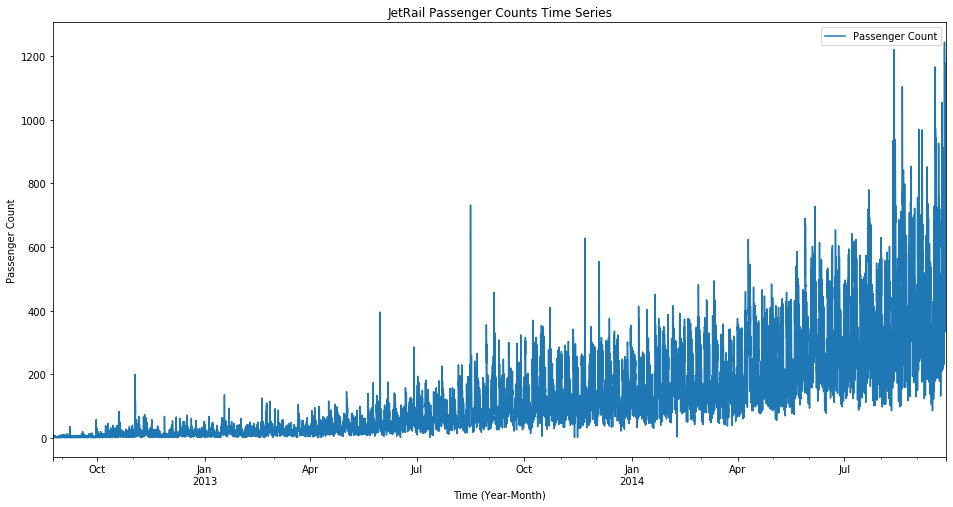

In [19]:
# Create Figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,8))

# Plot the time series data
train_ts.plot(ax=axes, label="Passenger Count")
axes.set_title("JetRail Passenger Counts Time Series")
axes.set_xlabel("Time (Year-Month)")
axes.set_ylabel("Passenger Count")
axes.legend(loc="best")

From this initial plot, we can infer that there is an increasing trend in the series (the passenger count is increasing with time).  We can also see that there are several points where the number of passengers increases significantly.  These spikes may be due to an event or other reason that caused an increase in ridership.

### Exploring the Data (Exploratory Data Analysis)

Earlier, we identified the following hypotheses:
* Passenger counts will increase over time, as the population and business growth have a general upward trend.
* Passenger counts will be highest from May through October, as that is when tourists generally visit the area.
* Passenger counts will be higher on weekdays in comparison to weekends, as people travel to work on weekdays.
* Passenger counts will be highest during peak hours when people are traveling to/from work, school, etc.

Our next step is to analyze the data to make inferences about the data related to these hypotheses.

Text(0, 0.5, 'Passenger Count')

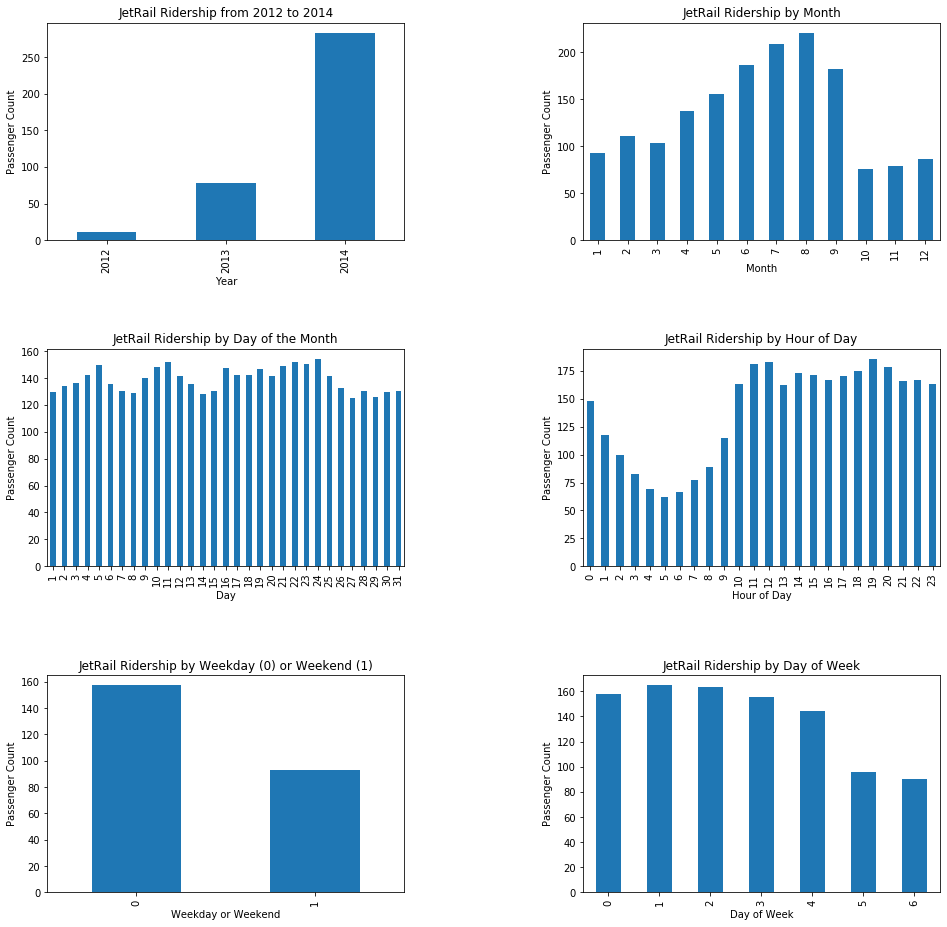

In [20]:
# Create Figure and axes objects
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,16))

# Adjust the spacing around the subplots
fig.subplots_adjust(wspace=0.5, hspace=0.5)

# Determine if the passenger counts are increasing over time
train.groupby("year")["Count"].mean().plot.bar(ax=axes[0,0])
axes[0,0].set_title("JetRail Ridership from 2012 to 2014")
axes[0,0].set_xlabel("Year")
axes[0,0].set_ylabel("Passenger Count")

# Determine if the passenger counts increase from May to October
train.groupby("month")["Count"].mean().plot.bar(ax=axes[0,1])
axes[0,1].set_title("JetRail Ridership by Month")
axes[0,1].set_xlabel("Month")
axes[0,1].set_ylabel("Passenger Count")

# Determine if the day of the month impacts the passenger counts
train.groupby("day")["Count"].mean().plot.bar(ax=axes[1,0])
axes[1,0].set_title("JetRail Ridership by Day of the Month")
axes[1,0].set_xlabel("Day")
axes[1,0].set_ylabel("Passenger Count")

# Determine if the hour of the day impacts the passenger counts
train.groupby("hour")["Count"].mean().plot.bar(ax=axes[1,1])
axes[1,1].set_title("JetRail Ridership by Hour of Day")
axes[1,1].set_xlabel("Hour of Day")
axes[1,1].set_ylabel("Passenger Count")

# Determine if more passengers ride on weekdays
train.groupby("weekend")["Count"].mean().plot.bar(ax=axes[2,0])
axes[2,0].set_title("JetRail Ridership by Weekday (0) or Weekend (1)")
axes[2,0].set_xlabel("Weekday or Weekend")
axes[2,0].set_ylabel("Passenger Count")

# Determine if the day of the week impacts the passenger count
train.groupby("dayOfWeek")["Count"].mean().plot.bar(ax=axes[2,1])
axes[2,1].set_title("JetRail Ridership by Day of Week")
axes[2,1].set_xlabel("Day of Week")
axes[2,1].set_ylabel("Passenger Count")

Based on the above plots, the passenger count is increasing each year.  In addition, we can see that the passenger count increases May through September.  Currently, the training dataset does not include any information starting in October 2014, so it is difficult to confirm that October also sees higher passenger counts.  The day of the month does not appear to matter, but the hour of the day does impact ridership.  Ridership is higher on weekdays, which is confirmed by looking at the average passenger count for each day of the week.

### Visualizing the Time Series

Now that we have taken a basic look at the training dataset, our next step is to visualize the time series.

The more frequent the observations within a dataset, the higher the noise is likely to be.  To remove some of this noise, we can aggregate the hourly time series to daily, weekly, and monthly time series.  This aggregation will make the time series more stable and easier to model.

In [21]:
# Create an hourly time series using the average value for each hour
hourly = train.resample("H").mean()

In [22]:
# Create daily time series using the daily mean
daily = train.resample("D").mean()

In [23]:
# Create weekly time series using the weekly mean
weekly = train.resample("W").mean()

In [24]:
# Create monthly time series using the monthly mean
monthly = train.resample("M").mean()

Text(0.5, 1.0, 'Monthly Time Series')

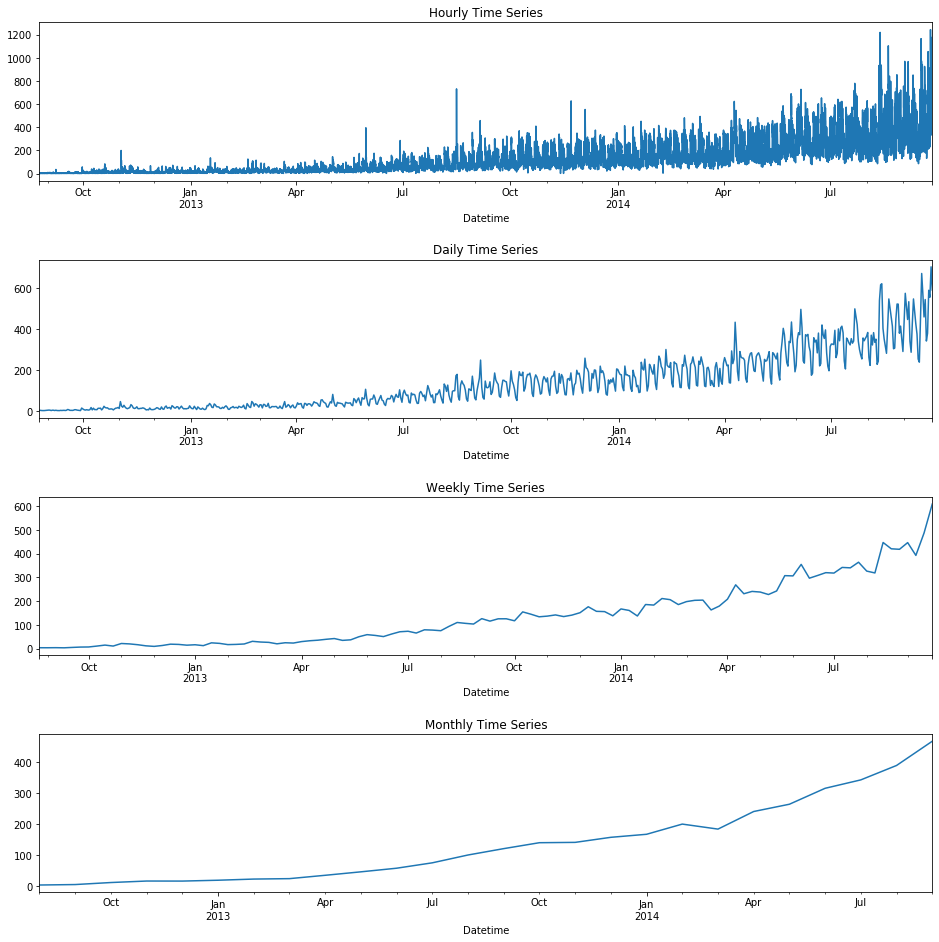

In [25]:
# Visualize the resampled time series data
# Create Figure and axes objects
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16,16))

# Adjust the spacing around the subplots
fig.subplots_adjust(wspace=0.5, hspace=0.5)

# Plot the hourly time series
hourly["Count"].plot(ax=axes[0])
axes[0].set_title("Hourly Time Series")

# Plot the daily time series
daily["Count"].plot(ax=axes[1])
axes[1].set_title("Daily Time Series")

# Plot the weekly time series
weekly["Count"].plot(ax=axes[2])
axes[2].set_title("Weekly Time Series")

# Plot the monthly time series
monthly["Count"].plot(ax=axes[3])
axes[3].set_title("Monthly Time Series")

From these plots, we can see that the time series is becoming more and more stable when we aggregate the data on a daily, weekly, and monthly basis.  But, it would be difficult to convert the monthly and weekly predictions to hourly predictions.  We first would need to convert the monthly information to weekly, then daily, and then hourly to achieve that goal.

Although hourly values are too granular for this analysis project, daily provides good detail while removing some noise.  As a result, we will use the hourly values for our purposes.

### Partitioning the Dataset

Now that we have validated our hypotheses and determined that daily values are the most appropriate for our purposes, the next step is to partition the existing dataset into training and validation datasets.

When creating these datasets for building the model, the validation dataset must have the following properties:
* The validation dataset should have the true values of the dependent variable against which the predictions can be checked.  Therefore, we cannot use the existing validation dataset for this purpose (as it does not include values for the outcome).
* The model should not be trained on the validation dataset.  Therefore, we cannot train the model on the training dataset and validate using that data as well.

As a result, we typically take the existing training dataset and partition it into a new training dataset and a new validation dataset.  While there are many ways to partition a dataset, we will use a time-based split.

In [26]:
# The validation dataset will be the last three months of the existing training dataset.
val_data = pd.DataFrame(daily.ix["2014-06-25":"2014-09-25"]["Count"])
val_data.head(10)

,Count
Datetime,
2014-06-25,353.666667
2014-06-26,395.250000
2014-06-27,282.333333
2014-06-28,218.250000
2014-06-29,196.250000
2014-06-30,314.500000
2014-07-01,326.500000
2014-07-02,326.083333
2014-07-03,323.916667


In [27]:
# The training dataset will be all the other months in the existing training dataset.
train_data = pd.DataFrame(daily.ix["2012-08-25":"2014-06-24"]["Count"])
train_data.head()

,Count
Datetime,
2012-08-25,3.166667
2012-08-26,3.666667
2012-08-27,2.583333
2012-08-28,2.416667
2012-08-29,2.500000


Text(0, 0.5, 'Passenger Count')

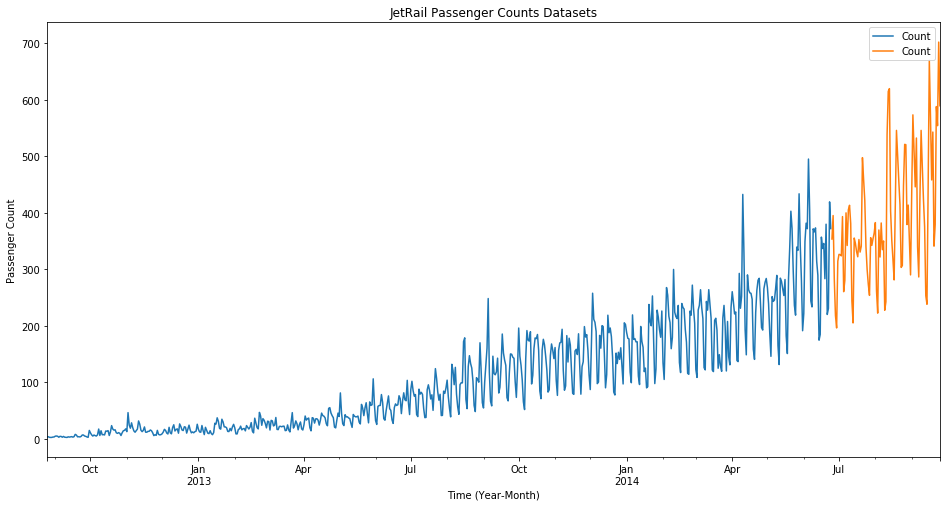

In [28]:
# Visualize how the existing training dataset was split to create these partitions
# Create Figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,8))

# Plot the time series data
train_data.plot(ax=axes)
val_data.plot(ax=axes)
axes.set_title("JetRail Passenger Counts Datasets")
axes.set_xlabel("Time (Year-Month)")
axes.set_ylabel("Passenger Count")

### Using the Naive Approach to Forecasting

In the Naive approach to forecasting, we assume that the next expected point is equal to the last observed point.  There are several ways of handling this approach based on drift and seasonality.

In [29]:
# View the last 12 values in the training dataset
train_data.tail(12)

,Count
Datetime,
2014-06-13,289.583333
2014-06-14,174.583333
2014-06-15,184.666667
2014-06-16,357.083333
2014-06-17,336.916667
2014-06-18,345.833333
2014-06-19,283.416667
2014-06-20,379.916667
2014-06-21,220.083333


In [30]:
# Generate the naive forecast using only the last value in the training dataset
naive_ts = train_data.iloc[-1]

# Output the forecast for the next value
naive_ts

Count    372.166667
Name: 2014-06-24 00:00:00, dtype: float64

In [31]:
# Generate the naive forecast using a drift of 2% per quarter
drift = 1 + 0.02
naive_ts_drift = train_data.iloc[-1] * drift

# Output the forecast for the next value using drift
naive_ts_drift

Count    379.61
Name: 2014-06-24 00:00:00, dtype: float64

In [32]:
# Generate the naive forecase using seasonal change
seasonal = 1 + 0.0063
naive_ts_seasonal = train_data.iloc[-1] * seasonal

# Output the forecast for the next value using seasonal change
naive_ts_seasonal

Count    374.511317
Name: 2014-06-24 00:00:00, dtype: float64

In [33]:
# Create a naive forecast that can be used for visualization
dd = np.asarray(train_data.Count)
y_hat = val_data.copy()
y_hat["naive"] = dd[len(dd) - 1]

Text(0, 0.5, 'Passenger Count')

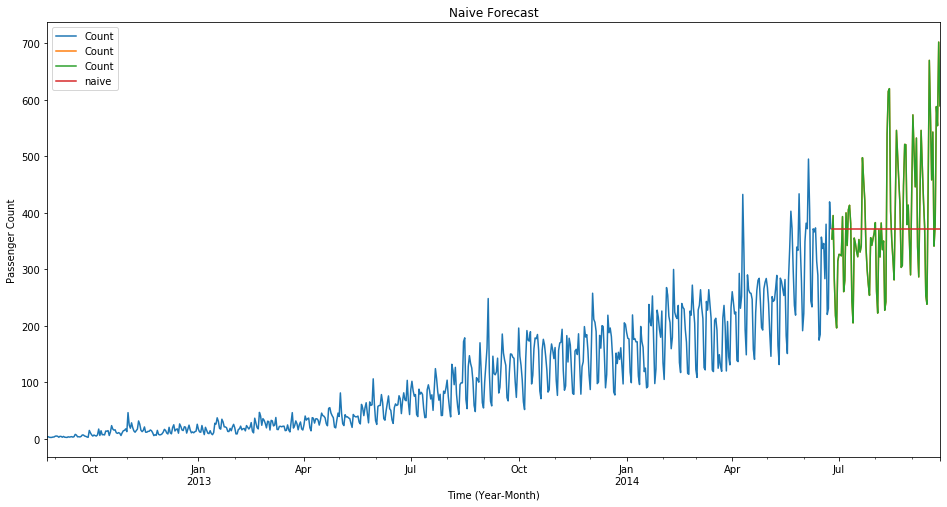

In [34]:
# Visualize the naive forecast
# Create Figure and axes objects
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,8))

# Plot the time series data
train_data.plot(ax=axes)
val_data.plot(ax=axes)
y_hat.plot(ax=axes)
axes.set_title("Naive Forecast")
axes.set_xlabel("Time (Year-Month)")
axes.set_ylabel("Passenger Count")

# References
> (c) 2019 Arih Ali Khan.  Code and dataset from https://www.kaggle.com/code/arifali77/time-series-forecasting-jetrail/notebook.

# For Homework

Obtain a FRED dataset.  Create at least one visualization of the dataset.  

Partition the dataset into a training dataset and a validation dataset.  Visualize the training and validation datasets.

Use the training dataset to calculate a naive forecast, a naive + drift forecast, and a naive plus seasonal forecast.

CHALLENGE:  Try to create a visualization for each of the forecasts (similar to the one shown above).